In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from rasterio.errors import RasterioIOError
import csv
from skimage import io
from pyproj import Transformer
import requests
from PIL import Image
import sys
from io import BytesIO
import kelp_tools as kt
import cupy as cp

In [2]:
tile = '11SKU'
location = 'Isla_vista_kelp'
cloud_cover_threshold = .25
save_mask = True
save_classification = True
path = os.path.join(r'/mnt/h/HLS_data/imagery',location,tile)
#path = r'C:\Users\attic\HLS_Kelp\imagery\Isla_vista_kelp_2018\11SKU'
item = 'HLS.S30.T11SKU.2017297T184441.v2.0'
dem_path = r'/mnt/c/Users/attic/HLS_Kelp/imagery/Socal_DEM.tiff'
img_path = os.path.join(path, item)
show_dem = True
use_kmeans = False

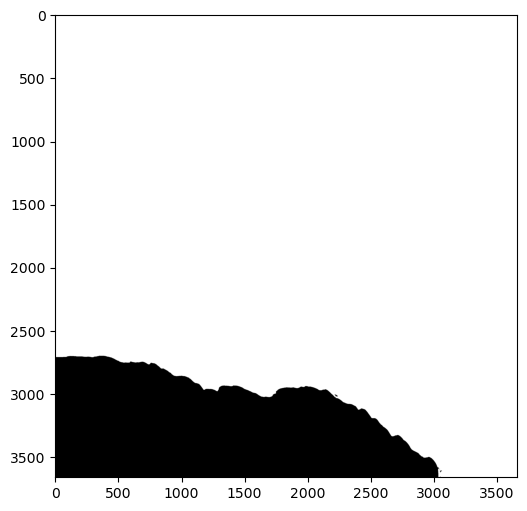

In [5]:


img_files = kt.filter_and_sort_files(img_path,item)

geotiff_path = os.path.join(img_path, img_files[0])

land_mask = kt.create_land_mask(geotiff_path, dem_path=dem_path, show_image=show_dem, as_numpy=True)

In [6]:
##==========Fmask Cloud mask==========##

cloud_land_mask, cloud_but_not_land_mask, percent_cloud_covered = kt.create_qa_mask(land_mask, img_path=img_path)

##==========Create stacked np array, Apply landmask==========##
img_bands = []
crs = None
transform = None
try:
    for file in img_files:
        with rasterio.open(os.path.join(img_path, file)) as src:
            img_bands.append(cp.where(cloud_land_mask, 0, cp.asarray(src.read(1))))
            if(transform is None):
                transform = src.transform
                crs= src.crs
except RasterioIOError as e:
    print(f"Error reading file {file} in granule {item}: {e}")
    sys.exit()

img = np.stack(img_bands, axis=0)
n_bands, height, width = img.shape
img_normalized = kt.normalize_img(img,flatten=False)

In [8]:
ocean_mask = (~land_mask & ~cp.asnumpy(cloud_but_not_land_mask))
#cloud_but_not_land_mask #This is a reminder to use this pre-made mask 

combined_mask = cp.full(ocean_mask.shape, 1)
combined_mask[land_mask] = 3
combined_mask[cp.asnumpy(cloud_but_not_land_mask)] = 2
combined_mask[cp.asnumpy(ocean_mask)] = 1

plt.figure(figsize=(20, 10))
plt.imshow(cp.asnumpy(combined_mask), cmap='Blues')
plt.show()

CUDARuntimeError: cudaErrorIllegalAddress: an illegal memory access was encountered

In [ ]:
if save_classification:
    if not os.path.isdir (r'C:\Users\attic\HLS_Kelp\imagery\rf_training_unclassified'):
        os.mkdir(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_unclassified')
    classification_path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_unclassified',f'{item}_kelp.tif') 
    height, width = combined_mask.shape
    reshaped_normalized_img = img_normalized
    combined_img = np.dstack((reshaped_normalized_img,combined_mask))

    plt.figure(figsize=(6, 6))
    plt.imshow(combined_img[:,:,6], cmap='gray')
    plt.show()  

    num_bands = 7
    data_type = rasterio.uint8
    profile = {
        'driver': 'GTiff',
        'width': width,
        'height': height,
        'count': 7,  # one band
        'dtype': data_type,  # assuming binary mask, adjust dtype if needed
        'crs': crs,
        'transform': transform,
        'nodata': 0  # assuming no data is 0
    }
    # Write the land mask array to GeoTIFF
    with rasterio.open(classification_path, 'w', **profile) as dst:
        for i in range(num_bands):
            dst.write(combined_img[:,:,i].astype(data_type), i + 1)